In [1]:
import json
import io
import contextlib
import traceback
import os
from typing import TypedDict, List, Optional, Dict, Any

# LangGraph imports
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
import nbformat # For Jupyter notebook creation
import pandas as pd # For mock data and potential use in generated code


# --- Agent State Definition ---
class AgentState(TypedDict):
    objective: str
    plan: Optional[List[Dict[str, Any]]]  # List of tasks, e.g., {"task_id": 1, "description": "Load data"}
    current_task_id: Optional[int]
    
    # For the current task being processed
    current_task_description: Optional[str]
    generated_code: Optional[str]
    code_execution_output: Optional[str] 

    reflection_notes: Optional[str]
    review_feedback: Optional[Dict[str, Any]] # {"status": "approved", "comment": "..."} or {"status": "revise", "comment": "..."}
    
    # Accumulating results
    completed_tasks_history: List[Dict[str, Any]] 
    notebook_content: List[Dict[str, Any]] # List of cells for nbformat

    # Control flow and error tracking
    error_count: int # Cumulative errors during code execution
    max_task_revisions: int # Max revisions for a single task before replan
    current_task_revisions: int # Current revision count for the active task
    max_overall_iterations: int # Max loops through orchestrator to prevent runaway execution
    iteration_count: int # Overall iterations through the orchestrator
    final_output: Optional[str] # Final message upon completion or termination


In [2]:
import operator
from typing import TypedDict, List, Optional

from langgraph.graph import StateGraph, END

# --- Minimal State Definition ---
class AgentState(TypedDict):
    """A minimal state for demonstrating the workflow structure."""
    objective: Optional[str]
    feedback: Optional[str]
    fatal_error: bool
    review_status: Optional[str] # e.g., 'continue', 'end', 'replan'
    steps_taken: int
    tools: List[str]  # Added tools list

# --- Node Functions ---

def orchestrator_agent(state: AgentState) -> dict:
    """Orchestrator agent with tool management."""
    print("--- Orchestrator Node ---")
    tools = state.get("tools", [])
    if not tools:
        tools = ["code_generator", "data_analyzer", "visualizer"]
    return {
        "steps_taken": state.get("steps_taken", 0) + 1,
        "tools": tools
    }

def tool_agent(state: AgentState) -> dict:
    """Tool agent that executes specific tools."""
    print("--- Tool Node ---")
    tools = state.get("tools", [])
    print(f"Executing tools: {tools}")
    return {"steps_taken": state.get("steps_taken", 0) + 1}

def coder_agent(state: AgentState) -> dict:
    """Coder agent with tool usage."""
    print("--- Coder Node ---")
    tools = state.get("tools", [])
    print(f"Available tools: {tools}")
    return {"steps_taken": state.get("steps_taken", 0) + 1}

def reflection_agent(state: AgentState) -> dict:
    """Reflection agent with end condition."""
    print("--- Reflection Node ---")
    steps = state.get("steps_taken", 0)
    if steps >= 10:  # End after 10 steps
        return {"fatal_error": True, "steps_taken": steps + 1}
    return {"fatal_error": False, "steps_taken": steps + 1}

def reviewer_agent(state: AgentState) -> dict:
    """Reviewer agent with enhanced status handling."""
    print("--- Reviewer Node ---")
    steps = state.get("steps_taken", 0)
    if steps < 5:
        status = "continue"
        feedback = ""
    else:
        status = "end"
        feedback = "Maximum steps reached"
    print(f"    Reviewer decision: {status}")
    return {
        "review_status": status,
        "feedback": feedback,
        "steps_taken": steps + 1
    }

# --- Conditional Edge Functions ---

def reflector_next_step(state: AgentState) -> str:
    """Enhanced reflector routing with end condition."""
    print("--- Reflector Decision ---")
    if state.get("fatal_error", False):
        print("    -> END (Fatal Error)")
        return "end"
    elif state.get("steps_taken", 0) >= 10:
        print("    -> END (Max Steps)")
        return "end"
    else:
        print("    -> Coder")
        return "coder"

def reviewer_next_step(state: AgentState) -> str:
    """Enhanced reviewer routing with tool feedback."""
    print("--- Reviewer Decision ---")
    status = state.get("review_status", "end")
    feedback = state.get("feedback", "")

    if feedback:
        print("    -> Orchestrator (Feedback)")
        return "orchestrator"
    elif status == "continue":
        print("    -> Coder (Continue)")
        return "coder"
    else:
        print("    -> END")
        return "end"

def code_writer(state):
    pass
def break_down_step(state):
    pass

# --- Build the Graph ---

print("Building the LangGraph workflow...")

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("orchestrator", orchestrator_agent)
workflow.add_node("break_down_step", break_down_step)

workflow.add_node("coder", coder_agent)
workflow.add_node("reflector", reflection_agent)
workflow.add_node("reviewer", reviewer_agent)

workflow.add_node("code_writer", code_writer)

# Set entry point
workflow.set_entry_point("orchestrator")

# Add edges
workflow.add_edge("orchestrator", "break_down_step")
workflow.add_edge("break_down_step", "coder")

workflow.add_edge("coder", "reflector")  # Changed from tool to reflector
workflow.add_edge("reflector", "coder")  # Added reflector to coder edge

workflow.add_edge("reflector", "reviewer")  # Added reflector to coder edge
workflow.add_edge("reflector", "code_writer")  # Added reflector to coder edge

workflow.add_edge("orchestrator", END)  # Added reflector to coder edge

# Add conditional edge from reviewer
workflow.add_edge(
    "reviewer","orchestrator")

# Compile the graph
app = workflow.compile()

Building the LangGraph workflow...


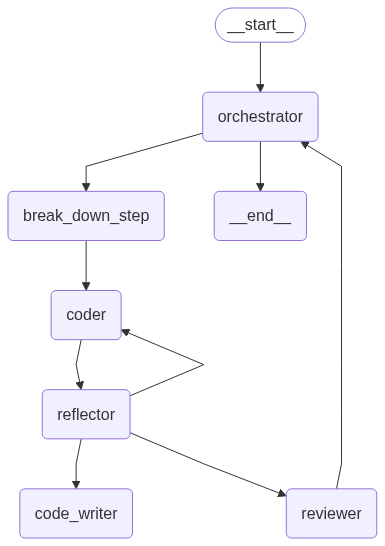

In [3]:
app

In [1]:
# Create a crew with just the orchestrator

from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.messages import HumanMessage, SystemMessage
import json
import os

with open('config.json', 'r') as f:
    config = json.load(f)

# Set OpenAI environment variables
os.environ["OPENAI_API_KEY"] = config['apiKey']
os.environ["OPENAI_API_BASE"] = config['baseURL']
os.environ["OPENAI_PUBLISHER"] = config['publisher']

# Initialize LangChain's ChatOpenAI
llm = ChatOpenAI(
    api_key=config['apiKey'],
    model=config['model'],
    base_url="https://models.github.ai/inference",
    temperature=0.7
)

# Define the system prompt for planning
PLANNER_SYSTEM_PROMPT = """You are an expert project manager and data science planner. Your role is to break down objectives into clear, actionable steps.

Your planning should:
1. Be extremely detailed and specific
2. Include all necessary steps
3. Consider dependencies between steps
4. Account for potential challenges
5. Define clear success criteria

For each step, you must specify:
- What needs to be done
- Required inputs
- Expected outputs
- Success criteria
- Potential challenges to handle

Format your response as a clear, numbered list of steps."""

# Define the planning chain
def create_planning_chain():
    # Create the prompt template
    prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content=PLANNER_SYSTEM_PROMPT),
        HumanMessage(content="{objective}")
    ])
    
    # Create the chain
    chain = (
        {"objective": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    return chain

def plan_objective(objective):
    """
    Creates a detailed plan for the given objective using LangChain.
    
    Args:
        objective (str): The objective to plan for
        
    Returns:
        str: The detailed plan
    """
    try:
        # Create the planning chain
        planning_chain = create_planning_chain()
        
        # Generate the plan
        plan = planning_chain.invoke(objective)
        
        return plan
    except Exception as e:
        print(f"Error during planning: {e}")
        return None
